# Breast Cancer Gene Expression Predictor on GSE65194

by mikeph_

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt


# Load expression data (ignore GEO header lines)
expr = pd.read_csv(
    "data/GSE45827_series_matrix.txt",
    sep="\t",
    comment="!",
    index_col=0
)

# Transpose: samples × genes
X = expr.T

# Convert to numeric
X = X.apply(pd.to_numeric, errors="coerce")
X = X.fillna(X.mean())

print("Expression shape:", X.shape)

labels = []

with open("data/GSE45827_series_matrix.txt") as f:
    for line in f:
        if line.startswith("!Sample_characteristics_ch1"):
            values = line.strip().split("\t")[1:]
            for v in values:
                if ("cancer" in v.lower()) or ("tumor" in v.lower()):
                    labels.append(1)
                else:
                    labels.append(0)
            break  # IMPORTANT: stop after first matching line

y = np.array(labels)

print("Labels length:", len(y))
assert X.shape[0] == y.shape[0], \
    f"Mismatch: {X.shape[0]} samples vs {y.shape[0]} labels"

print("Samples and labels aligned")


Expression shape: (155, 29873)
Labels length: 155
Samples and labels aligned


## Train Model

In [2]:
# Train function
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

selector = SelectKBest(score_func=f_classif, k=200)

X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)

print("Selected features:", X_train_sel.shape[1])

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    solver="saga",
    l1_ratio=0.5,   # elastic net
    C=0.5,
    max_iter=10000,
    random_state=42
)

model.fit(X_train_scaled, y_train)

Selected features: 200


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",0.5
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.5
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

## Evaluation

In [3]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    model,
    scaler.fit_transform(selector.fit_transform(X, y)),
    y,
    cv=cv,
    scoring="roc_auc"
)

print("CV ROC-AUC scores:", scores)
print("Mean ROC-AUC:", scores.mean())
print("Std ROC-AUC:", scores.std())

#permutation test
from sklearn.model_selection import permutation_test_score

score, perm_scores, pvalue = permutation_test_score(
    model,
    scaler.fit_transform(selector.fit_transform(X, y)),
    y,
    scoring="roc_auc",
    cv=cv,
    n_permutations=100,
    random_state=42
)

print("Permutation ROC-AUC:", score)
print("Permutation p-value:", pvalue)

# leave one out test
from sklearn.model_selection import LeaveOneOut, cross_val_score

loo = LeaveOneOut()

acc_scores = cross_val_score(
    model,
    scaler.fit_transform(selector.fit_transform(X, y)),
    y,
    cv=loo,
    scoring="accuracy"
)

print("LOOCV accuracy:", acc_scores.mean())




CV ROC-AUC scores: [1. 1. 1. 1. 1.]
Mean ROC-AUC: 1.0
Std ROC-AUC: 0.0
Permutation ROC-AUC: 1.0
Permutation p-value: 0.009900990099009901
LOOCV accuracy: 0.9935483870967742


## Gene Expression

In [4]:
selected_genes = X.columns[selector.get_support()]
coef = model.coef_[0]

gene_importance = (
    pd.DataFrame({
        "Gene": selected_genes,
        "Weight": coef
    })
    .sort_values("Weight", ascending=False)
)

gene_importance.head(10)


,Gene,Weight
31,1559612_at,0.197923
62,1569760_at,0.190859
81,209006_s_at,0.189255
127,226663_at,0.178307
107,216834_at,0.167311
171,239251_at,0.163855
69,202803_s_at,0.158573
83,209201_x_at,0.151164
74,204174_at,0.150717
199,37892_at,0.147803


## Export Data

In [5]:
X.to_csv("output/expression_matrix.csv")

labels_df = pd.DataFrame({
    "sample_id": X.index,
    "label": y
})
labels_df.to_csv("output/labels.csv", index=False)

X_selected = X[selected_genes]
X_selected.to_csv("output/expression_selected_genes.csv")

gene_importance.to_csv("output/important_genes.csv", index=False)


## ROC and PCA

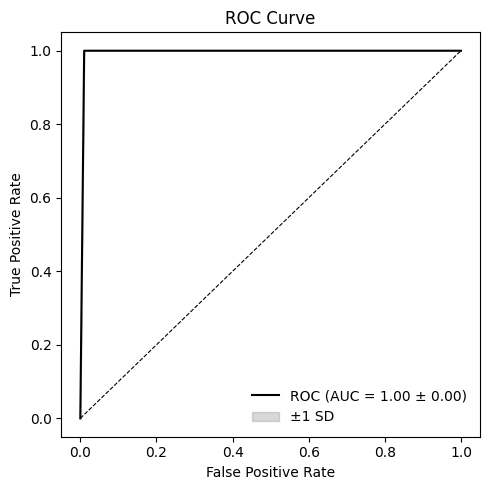

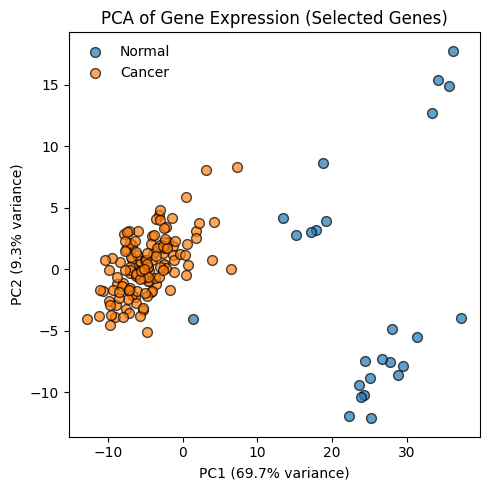

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample

# Predict probabilities
y_prob = model.predict_proba(X_test_sel)[:, 1]

# Bootstrap ROC
n_bootstraps = 1000
rng = np.random.RandomState(42)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i in range(n_bootstraps):
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test[indices])) < 2:
        continue

    fpr, tpr, _ = roc_curve(y_test[indices], y_prob[indices])
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

# Statistics
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

# Plot
plt.figure(figsize=(5, 5))
plt.plot(mean_fpr, mean_tpr, color="black",
         label=f"ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})")

plt.fill_between(
    mean_fpr,
    np.maximum(mean_tpr - std_tpr, 0),
    np.minimum(mean_tpr + std_tpr, 1),
    color="gray",
    alpha=0.3,
    label="±1 SD"
)

plt.plot([0, 1], [0, 1], linestyle="--", color="black", linewidth=0.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("output/roc_curve.pdf")
plt.show()

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Feature selection + scaling
X_all_sel = selector.transform(X)
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all_sel)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all_scaled)

pc1_var = pca.explained_variance_ratio_[0] * 100
pc2_var = pca.explained_variance_ratio_[1] * 100

# Plot
plt.figure(figsize=(5, 5))

plt.scatter(
    X_pca[y == 0, 0],
    X_pca[y == 0, 1],
    label="Normal",
    alpha=0.7,
    edgecolor="black",
    s=50
)

plt.scatter(
    X_pca[y == 1, 0],
    X_pca[y == 1, 1],
    label="Cancer",
    alpha=0.7,
    edgecolor="black",
    s=50
)

plt.xlabel(f"PC1 ({pc1_var:.1f}% variance)")
plt.ylabel(f"PC2 ({pc2_var:.1f}% variance)")
plt.title("PCA of Gene Expression (Selected Genes)")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("output/pca_plot.pdf")
plt.show()



# GSE65194

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    roc_curve,
    auc
)

# Selected genes from training
train_genes = X.columns[selector.get_support()]

# Training data with selected genes
X_train_sel = X[train_genes]

# Fit scaler on TRAINING data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)

# Fit PCA on TRAINING data only
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

pc1_var = pca.explained_variance_ratio_[0] * 100
pc2_var = pca.explained_variance_ratio_[1] * 100




# Load dataset

In [8]:
ext_csv = "data/GSE65194_series_matrix.txt"

# load dataset
expr_42568 = pd.read_csv(
    ext_csv,
    sep="\t",
    comment="!",
    index_col=0
)

# transpose to samples × genes
X_ext = expr_42568.T.apply(pd.to_numeric, errors="coerce")
X_ext = X_ext.fillna(X_ext.mean())

print("External expression shape:", X_ext.shape)

External expression shape: (178, 54673)


# Model pre-proccesing

In [9]:


# --- 1. Extract characteristics ---
characteristics = []

with open(ext_csv) as f:
    for line in f:
        if line.startswith("!Sample_characteristics_ch1"):
            values = [v.strip().strip('"') for v in line.strip().split("\t")[1:]]
            characteristics.append(values)

characteristics = np.array(characteristics)
print("Found characteristic rows:", characteristics.shape[0])

# --- 2. Identify sample_group row ---
sample_group_row = None

for row in characteristics:
    if any(v.lower().startswith("sample_group:") for v in row):
        sample_group_row = row
        break

if sample_group_row is None:
    raise RuntimeError("sample_group row not found in GEO file.")

# --- 3. Convert to binary labels ---
# Define cancer vs normal
cancer_groups = {"tnbc", "her2", "luminal a", "luminal b"}
normal_groups = {"healthy"}

y_ext = []
valid_idx = []

for i, v in enumerate(sample_group_row):
    group = v.split(":")[1].strip().lower()

    if group in cancer_groups:
        y_ext.append(1)
        valid_idx.append(i)
    elif group in normal_groups:
        y_ext.append(0)
        valid_idx.append(i)
    else:
        # exclude CellLine samples
        continue

y_ext = np.array(y_ext)

print("External labels (0=Normal, 1=Cancer):", np.bincount(y_ext))
print("Unique labels:", np.unique(y_ext))

assert len(np.unique(y_ext)) == 2, "Only one class found in external labels!"

# --- 4. Subset expression data to match labels ---
X_ext = X_ext.iloc[valid_idx]

# --- 5. Match genes and prepare external data ---
X_ext_common = X_ext.reindex(columns=train_genes, fill_value=0)

print(f"External data shape after aligning with training genes: {X_ext_common.shape}")
print(f"Scaler expects features: {len(train_genes)}")

# --- 6. Scale using training scaler ---
X_ext_scaled = scaler.transform(X_ext_common)
print("External data successfully scaled.")


Found characteristic rows: 4
External labels (0=Normal, 1=Cancer): [ 11 153]
Unique labels: [0 1]
External data shape after aligning with training genes: (164, 200)
Scaler expects features: 200
External data successfully scaled.


In [10]:
# Prediction and metrics
y_ext_prob = model.predict_proba(X_ext_scaled)[:, 1]
#y_ext_pred = model.predict(X_ext_scaled)

from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_ext, y_ext_prob)

# Example: pick threshold with highest F1
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Best threshold for F1:", best_threshold)

y_ext_pred_adjusted = (y_ext_prob >= best_threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_ext, y_ext_pred_adjusted))


Best threshold for F1: 0.9561162067656552
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.97      1.00      0.99       153

    accuracy                           0.98       164
   macro avg       0.99      0.82      0.88       164
weighted avg       0.98      0.98      0.97       164



# ROC-AUC Curve

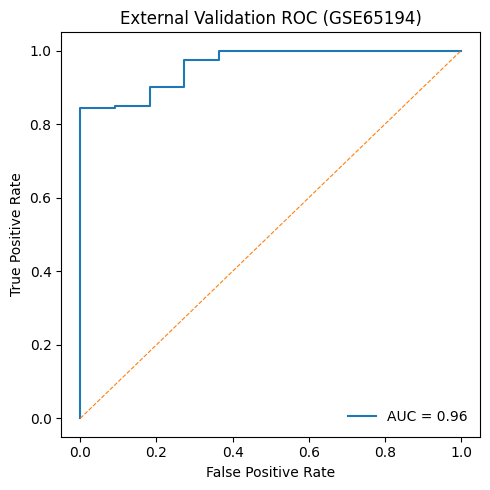

In [11]:
fpr, tpr, _ = roc_curve(y_ext, y_ext_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--", linewidth=0.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("External Validation ROC (GSE65194)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# PCA of GSE65194

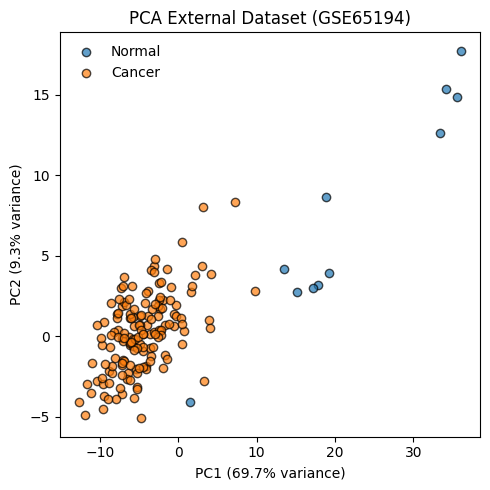

In [12]:
X_ext_pca = pca.transform(X_ext_scaled)

plt.figure(figsize=(5,5))
plt.scatter(
    X_ext_pca[y_ext == 0, 0],
    X_ext_pca[y_ext == 0, 1],
    label="Normal",
    alpha=0.7,
    edgecolor="black"
)
plt.scatter(
    X_ext_pca[y_ext == 1, 0],
    X_ext_pca[y_ext == 1, 1],
    label="Cancer",
    alpha=0.7,
    edgecolor="black"
)

plt.xlabel(f"PC1 ({pc1_var:.1f}% variance)")
plt.ylabel(f"PC2 ({pc2_var:.1f}% variance)")
plt.title("PCA External Dataset (GSE65194)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# PCA Training vs GSE65194

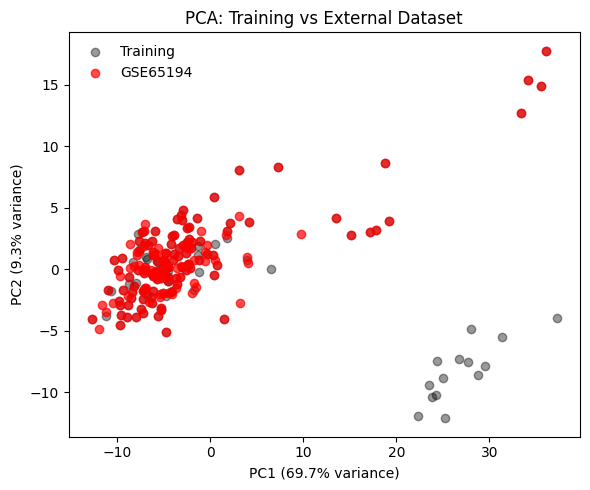

In [13]:
plt.figure(figsize=(6,5))

plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c="black",
    alpha=0.4,
    label="Training"
)

plt.scatter(
    X_ext_pca[:, 0],
    X_ext_pca[:, 1],
    c="red",
    alpha=0.7,
    label="GSE65194"
)

plt.xlabel(f"PC1 ({pc1_var:.1f}% variance)")
plt.ylabel(f"PC2 ({pc2_var:.1f}% variance)")
plt.title("PCA: Training vs External Dataset")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# Score Distribution

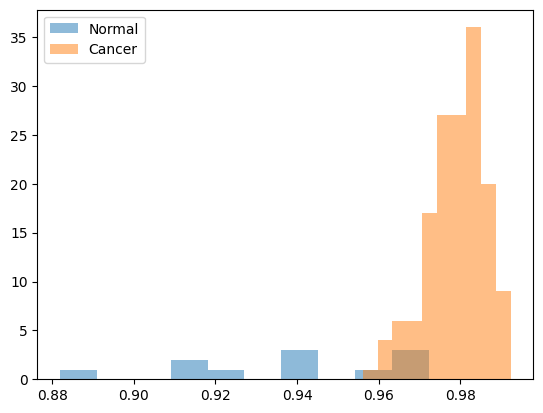

In [14]:
plt.hist(y_ext_prob[y_ext==0], alpha=0.5, label="Normal")
plt.hist(y_ext_prob[y_ext==1], alpha=0.5, label="Cancer")
plt.legend()
plt.show()


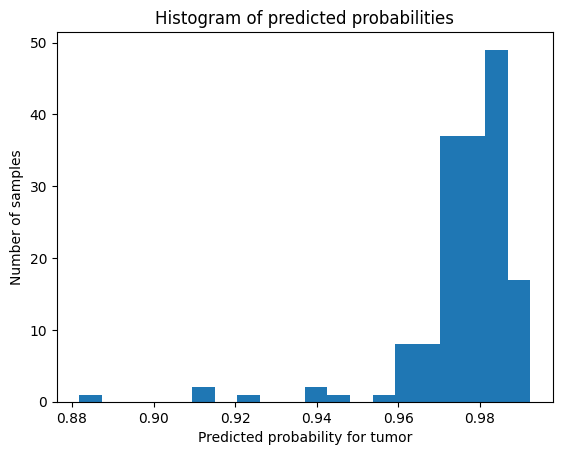

Min prob: 0.8818357201828678 Max prob: 0.9924392184457115
ok


In [15]:
plt.hist(y_ext_prob, bins=20)
plt.xlabel("Predicted probability for tumor")
plt.ylabel("Number of samples")
plt.title("Histogram of predicted probabilities")
plt.show()


# sanity check

print("Min prob:", y_ext_prob.min(), "Max prob:", y_ext_prob.max())

if y_ext_prob.max() <= 0.5:
    print("Model needs threshold adjustment.")
else:
    print("ok")
